In [2]:
!pip install seaborn
!pip install sklearn
!pip install pandas_profiling

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import re
import gc
from tqdm.notebook import trange, tqdm
import pandas as pd
import numpy as np
import zipfile
import copy
import time

%matplotlib inline

pd.set_option('display.max_columns',None)

In [3]:
useful_columns = ['Invoice/Item Number', 'Date', 'Store Number','Store Name',
       'City', 'Zip Code','County', 'Category Name', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
      'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
      'Sale (Dollars)', 'Volume Sold (Liters)','Volume Sold (Gallons)']

dtypes = {
'Invoice/Item Number':'object',
'Store Number':'int16',
'City':'object',
'County':'object' , 
    'Category Name':'object', 
    'Vendor Name':'object',
    'Item Number':'object', 
    'Item Description':'object', 
    'Pack':'int16',
    'Bottle Volume (ml)':'int16',
    'State Bottle Cost':'float16', 
    'State Bottle Retail':'float16', 
    'Bottles Sold':'float16',
    'Sale (Dollars)':'float16', 
    'Volume Sold (Liters)':'float16',
    'Volume Sold (Gallons)':'float16'
}

with zipfile.ZipFile('autodl-nas/Iowa_Liquor_Sales.csv.zip','r') as zipobj:
    df=zipobj.open('Iowa_Liquor_Sales.csv')
    #df = pd.read_csv('Iowa_Liquor_Sales.csv', parse_dates=['Date'], usecols=useful_columns,dtype=dtypes)
    
df = pd.read_csv(df, parse_dates=['Date'],usecols=useful_columns,dtype=dtypes)

/tmp/ipykernel_262/1999578732.py:30: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df, parse_dates=['Date'],usecols=useful_columns,dtype=dtypes)


In [12]:
df

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S24127700024,2015-02-19,3678,"Smoke Shop, The",1918 SE 14TH ST,DES MOINES,50320,POINT (-93.597011 41.570844),77.0,Polk,1031200.0,VODKA FLAVORED,380.0,Phillips Beverage Company,41783,Uv Blue Raspberry Vodka Mini,6,500,4.89,7.34,2,14.68,1.00,0.26
1,S15066200002,2013-10-10,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14TH ST,DES MOINES,50320,POINT (-93.596754 41.554101),77.0,Polk,1082900.0,MISC. IMPORTED CORDIALS & LIQUEURS,305.0,MHW Ltd,904969,Sabe Premiom Sake Double Barrel,6,750,14.99,22.49,6,134.94,4.50,1.19
2,S19323500030,2014-06-03,2607,Hy-Vee Wine and Spirits / Shenandoah,520 SO FREMONT,SHENANDOAH,51601,POINT (-95.385111 40.761736),73.0,Page,1062200.0,PUERTO RICO & VIRGIN ISLANDS RUM,434.0,Luxco-St Louis,45277,Paramount White Rum,12,1000,4.34,6.51,12,78.12,12.00,3.17
3,S23334500013,2015-01-06,4810,Kum & Go #518 / Ankeny,3603 NE OTTERVIEW CIRCLE,ANKENY,50021,POINT (-93.572458 41.760989),77.0,Polk,1062200.0,PUERTO RICO & VIRGIN ISLANDS RUM,35.0,"Bacardi U.S.A., Inc.",43121,Bacardi Superior Rum Mini,12,500,5.54,8.31,1,8.31,0.50,0.13
4,S09742200010,2012-12-27,4025,Karam Kaur Khasriya Llc,702 13TH ST,BELLE PLAINE,52208,POINT (-92.277759 41.897052),6.0,Benton,1012100.0,CANADIAN WHISKIES,260.0,Diageo Americas,11298,Crown Royal Canadian Whisky,6,1750,31.00,46.49,2,92.98,3.50,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666758,S10600200004,2013-02-13,3864,Hometown Foods / Schaller,201 S MAIN ST PO BX 40,SCHALLER,51053,POINT (-95.29346 42.499481),81.0,Sac,1071100.0,AMERICAN COCKTAILS,421.0,"Sazerac Co., Inc.",59231,Ice Box Mudslide,6,1750,5.75,9.13,6,54.78,10.50,2.77
19666759,S23597800012,2015-01-21,5065,Circle S Gordon Drive,"2520, GORDON DR",SIOUX CITY,51106,POINT (-96.376341 42.489845),97.0,Woodbury,1081600.0,WHISKEY LIQUEUR,421.0,"Sazerac Co., Inc.",64863,Fireball Cinnamon Whiskey,48,200,3.33,5.00,4,20.00,0.80,0.21
19666760,S29278700041,2015-11-24,3400,Last Stop Beverage Shop,2839 E. UNIVERSITY,DES MOINES,50317,POINT (-93.561517 41.600476),77.0,Polk,1031080.0,VODKA 80 PROOF,380.0,Phillips Beverage Company,37336,Uv Vodka,12,750,6.50,9.75,12,117.00,9.00,2.38
19666761,S04908000004,2012-04-05,2579,Hy-Vee Food Store / Grinnell,320 WEST STREET SOUTH,GRINNELL,50112,POINT (-92.727343 41.7283),79.0,Poweshiek,1062200.0,PUERTO RICO & VIRGIN ISLANDS RUM,35.0,"Bacardi U.S.A., Inc.",43128,Bacardi Superior Rum,6,1750,14.67,22.00,6,132.00,10.50,2.77


In [13]:
# df1=df.iloc[:,0:12]

In [14]:
# df2=df.iloc[:,12:24]

# 生成数据报告

In [15]:
# %%time

# pfr = pandas_profiling.ProfileReport(df1)
# pfr.to_file("autodl-nas/ProfileReport1.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 15min 23s, sys: 3min 47s, total: 19min 11s
Wall time: 17min 43s


In [ ]:
# %%time

# pfr = pandas_profiling.ProfileReport(df2)
# pfr.to_file("autodl-nas/ProfileReport2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
## IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 158324     尝试对df重置索引试试

## PicklingError: Could not pickle the task to send it to the workers.

In [4]:
## 创建一个原数据集副本df_copy

df_copy=copy.deepcopy(df)

In [5]:
## 内存使用情况
df.memory_usage().sum() / 1024**2

## 1838.057424545288

1838.057424545288

In [6]:
def basic_preprocessing(df):
    
    #选取所有为object的数据列
    object_column_list = list(df.dtypes[df.dtypes == object].index)
    
    # 把object类型的列全部转为小写
    for object_column in object_column_list:
        df.loc[:,object_column] = df.loc[:,object_column].str.lower().str.strip().str.split().str.join(' ')
        gc.collect()
    
    # 部分商店名称为商店（或连锁店）+商店后缀（加盟店）+数字，将其拆开
    df[['Store Name','Store Subname']] = df['Store Name'].str.rsplit(pat=" / ", expand=True, n=1)
    df[['Store Name','Store SubNumber']] = df['Store Name'].str.rsplit(pat=" #", expand=True, n=1)
    
    return df

In [7]:
%%time

basic_preprocessing(df)


# CPU times: user 6min 44s, sys: 40.2 s, total: 7min 24s
# Wall time: 7min 24s

CPU times: user 8min 14s, sys: 58.6 s, total: 9min 12s
Wall time: 9min 12s


,Invoice/Item Number,Date,Store Number,Store Name,City,Zip Code,County,Category Name,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Subname,Store SubNumber
0,s24127700024,2015-02-19,3678,"smoke shop, the",des moines,50320,polk,vodka flavored,phillips beverage company,41783,uv blue raspberry vodka mini,6,500,4.890625,7.339844,2.0,14.679688,1.000000,0.260010,None,None
1,s15066200002,2013-10-10,2633,hy-vee,des moines,50320,polk,misc. imported cordials & liqueurs,mhw ltd,904969,sabe premiom sake double barrel,6,750,14.992188,22.484375,6.0,135.000000,4.500000,1.190430,des moines,3 / bdi
2,s19323500030,2014-06-03,2607,hy-vee wine and spirits,shenandoah,51601,page,puerto rico & virgin islands rum,luxco-st louis,45277,paramount white rum,12,1000,4.339844,6.511719,12.0,78.125000,12.000000,3.169922,shenandoah,None
3,s23334500013,2015-01-06,4810,kum & go,ankeny,50021,polk,puerto rico & virgin islands rum,"bacardi u.s.a., inc.",43121,bacardi superior rum mini,12,500,5.539062,8.312500,1.0,8.312500,0.500000,0.130005,ankeny,518
4,s09742200010,2012-12-27,4025,karam kaur khasriya llc,belle plaine,52208,benton,canadian whiskies,diageo americas,11298,crown royal canadian whisky,6,1750,31.000000,46.500000,2.0,93.000000,3.500000,0.919922,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666758,s10600200004,2013-02-13,3864,hometown foods,schaller,51053,sac,american cocktails,"sazerac co., inc.",59231,ice box mudslide,6,1750,5.750000,9.132812,6.0,54.781250,10.500000,2.769531,schaller,None
19666759,s23597800012,2015-01-21,5065,circle s gordon drive,sioux city,51106,woodbury,whiskey liqueur,"sazerac co., inc.",64863,fireball cinnamon whiskey,48,200,3.330078,5.000000,4.0,20.000000,0.799805,0.209961,None,None
19666760,s29278700041,2015-11-24,3400,last stop beverage shop,des moines,50317,polk,vodka 80 proof,phillips beverage company,37336,uv vodka,12,750,6.500000,9.750000,12.0,117.000000,9.000000,2.380859,None,None
19666761,s04908000004,2012-04-05,2579,hy-vee food store,grinnell,50112,poweshiek,puerto rico & virgin islands rum,"bacardi u.s.a., inc.",43128,bacardi superior rum,6,1750,14.671875,22.000000,6.0,132.000000,10.500000,2.769531,grinnell,None


<font size=7>数据清洗<font>
    
 <font size=4>空值查询处理<font>

In [16]:

%%time
df.isnull().any().sum()
#  10列存在空值

CPU times: user 27.9 s, sys: 2.61 s, total: 30.5 s
Wall time: 30.5 s


10

In [24]:
df.isnull().T.any().sum()   ##  数据集在进行文本分割后存在空集的行数为16619311

16619311

In [25]:
df_copy.isnull().T.any().sum()    ##  原数据集（没有进行文本分割前）存在空值 的数量仅为181386

181386

In [26]:
## 原数据空值分布

missing = df_copy.isnull().sum()/len(df_copy)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing


# Vendor Name            1.525416e-07
# State Bottle Cost      5.084721e-07
# State Bottle Retail    5.084721e-07
# Sale (Dollars)         5.084721e-07
# Category Name          1.273214e-03
# City                   4.064014e-03
# Zip Code               4.066302e-03
# County                 7.969232e-03

Vendor Name            1.525416e-07
State Bottle Cost      5.084721e-07
State Bottle Retail    5.084721e-07
Sale (Dollars)         5.084721e-07
Category Name          1.273214e-03
City                   4.064014e-03
Zip Code               4.066302e-03
County                 7.969232e-03
dtype: float64

<AxesSubplot:>

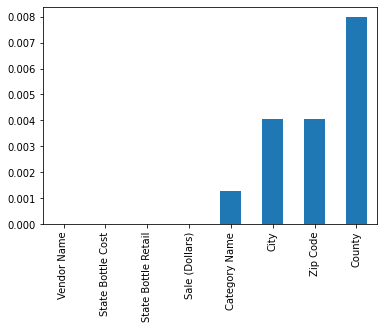

In [27]:
missing.plot.bar()

In [ ]:
##  文本分割后数据

missing = df.isnull().sum()/len(df)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

Vendor Name            1.525416e-07
State Bottle Cost      5.084721e-07
State Bottle Retail    5.084721e-07
Sale (Dollars)         5.084721e-07
Category Name          1.273214e-03
City                   4.064014e-03
County                 7.969232e-03
Store Subname          3.417586e-01
Zip Code               4.317598e-01
Store SubNumber        6.709722e-01
dtype: float64

<AxesSubplot:>

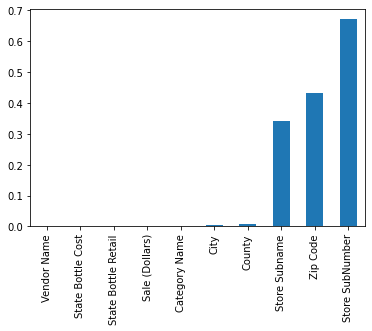

In [ ]:
missing.plot.bar()

如果后续分析没有使用坐标位置，那么大部分的空值可以忽略，然而通过查看坐标列信息，发现其数据信息为经纬度坐标轴，后续可以使用tableau的地图功能，所以该列信息比较重要。
尝试弃用storelocation进行后续清洗工作。
同时由于subname和subnumber缺失太多，一并删去。      

In [8]:
df.drop('Store Subname',axis = 1,inplace = True)

In [9]:
df.drop('Store SubNumber',axis = 1,inplace = True)

In [30]:
df.isnull().T.any().sum()

8578480

<font size=2>删除了store subname  以及 store subnumber后  发现zip code的缺失值占比分布竟然变大了   从原数据的0.004 变成了0.4  但是考虑到后续可能并不需要使用到zip code这个地区编码  因而只需要将zip code列进行删除即可<font>

In [32]:
##  删除了store subname  以及 store subnumber后  发现zip code的缺失值占比分布竟然变大了   从原数据的0.004 变成了0.4  但是考虑到后续可能并不需要使用到zip code这个地区邮政码  因而只需要将zip code列进行删除即可

missing = df.isnull().sum()/len(df)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

Vendor Name            1.525416e-07
State Bottle Cost      5.084721e-07
State Bottle Retail    5.084721e-07
Sale (Dollars)         5.084721e-07
Category Name          1.273214e-03
City                   4.064014e-03
County                 7.969232e-03
Zip Code               4.317598e-01
dtype: float64

<AxesSubplot:>

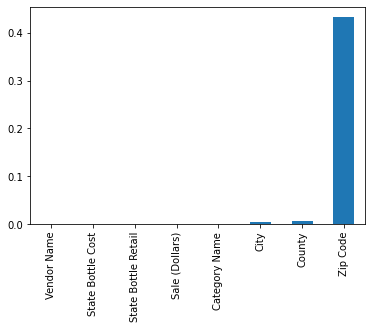

In [33]:
missing.plot.bar()

In [10]:
df.drop('Zip Code',axis = 1,inplace = True)

In [35]:
df.isnull().T.any().sum()    ##  在把  zip code 处理之后  空值数量与原数据集保持了一致     考虑是否直接把空值行进行删除？？  考虑到只会损失18万个数据量   好像是可以接受的   因而直接进行对存在空值行进行删除

181386

In [36]:
df.shape

(19666763, 18)

In [11]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [12]:
df.shape     ##  清除空值后剩余  19485377个数据

(19485377, 18)

<font size=4>重复值查询处理

In [39]:
df['Invoice/Item Number'].nunique()      ## 确认无重复值   nunique数量与df行数保持一致

19485377

<font size=4>异常值查询处理

<font size=2>将数据分为数值特征以及类别特征

In [13]:
int_data=[]
str_data=[]

for i in range(len(df.iloc[0])):
    if type(df.iloc[0,i]) in [np.int16,np.float16]:
        int_data.append(df.columns[i])
    else:
        str_data.append(df.columns[i])
        
print(int_data)
print(str_data)  


# ['Store Number', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']
# ['Invoice/Item Number', 'Date', 'Store Name', 'City', 'County', 'Category Name', 'Vendor Name', 'Item Number', 'Item Description']

['Store Number', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']
['Invoice/Item Number', 'Date', 'Store Name', 'City', 'County', 'Category Name', 'Vendor Name', 'Item Number', 'Item Description']


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19485377 entries, 0 to 19666762
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Invoice/Item Number    object        
 1   Date                   datetime64[ns]
 2   Store Number           int16         
 3   Store Name             object        
 4   City                   object        
 5   County                 object        
 6   Category Name          object        
 7   Vendor Name            object        
 8   Item Number            object        
 9   Item Description       object        
 10  Pack                   int16         
 11  Bottle Volume (ml)     int16         
 12  State Bottle Cost      float16       
 13  State Bottle Retail    float16       
 14  Bottles Sold           float16       
 15  Sale (Dollars)         float16       
 16  Volume Sold (Liters)   float16       
 17  Volume Sold (Gallons)  float16       
dtypes: datetime64[ns](1)

In [64]:
##  为什么bottle volume（ml） 会出现  负数以及 0 ？   可以考虑删除

df['Bottle Volume (ml)'].value_counts(dropna=False).sort_index()

-16608          2
-15216         24
-7608           2
 0             10
 12             1
 15             1
 20           992
 25           252
 50        293876
 100       107219
 150          672
 175           18
 200       704016
 250          858
 300        93446
 301          130
 355            7
 375      1962642
 400         1927
 425           26
 500       721984
 502          349
 600       215619
 603          194
 750      8737456
 800        19876
 850         2312
 900          897
 950          423
 1000     2584740
 1125         381
 1200       19050
 1420          63
 1500         150
 1508           3
 1750     3908794
 1800         694
 1850        1883
 1950         566
 2000          23
 2125          16
 2250         356
 2400        6789
 2550          42
 3000       94384
 3500         248
 3600         154
 3900          15
 4500          51
 4800         476
 6000        1231
 7580           1
 8928           8
 9000           3
 28392          1
 31500    

In [14]:
## 删除 bottle volume 为0 以及负数的值

df=df[df['Bottle Volume (ml)'] >0]

In [79]:
df['Pack'].value_counts(dropna=False).sort_index()

1        126210
2           603
3         15532
4         22747
5         38247
6       5282461
8         29282
9          1070
10       364552
12     11317019
15         1640
16          383
18          185
20          562
24      1765038
30          207
32            4
44        30412
48       488591
60          478
96            1
120           3
160           4
288         100
312          38
336           8
Name: Pack, dtype: int64

In [15]:
##  bottles sold 为什么可以是0 ？

df['Bottles Sold'].value_counts(dropna=False).sort_index()

0.0              9
1.0        2220312
2.0        2638104
3.0        1969523
4.0        1057445
            ...   
7632.0           1
7920.0           4
11120.0          1
11952.0          1
15000.0          2
Name: Bottles Sold, Length: 581, dtype: int64

In [16]:
##  删除bottles sold 等于0的行


df=df[df['Bottles Sold'] >0]

In [66]:
##  sale 销售金额为什么可以是有0?    以及为什么会有无穷数  inf

df['Sale (Dollars)'].value_counts().sort_index()

0.000000e+00    4919
1.299805e+00       2
1.339844e+00     177
1.349609e+00     225
1.429688e+00      28
                ... 
6.332800e+04       1
6.476800e+04       1
6.480000e+04       1
6.534400e+04       1
inf               35
Name: Sale (Dollars), Length: 11282, dtype: int64

In [17]:
##  删除销售金额为0  以及销售金额为无穷数的行

df=df[df['Sale (Dollars)']!=float('inf')]
df=df[df['Sale (Dollars)']>0]

In [68]:
##   同样存在0值

df['Volume Sold (Liters)'].value_counts().sort_index()

0.000000            10
0.020004           333
0.029999             1
0.040009           176
0.049988        111382
                 ...  
8504.000000          1
8960.000000          1
11120.000000         1
11816.000000         1
15000.000000         2
Name: Volume Sold (Liters), Length: 1312, dtype: int64

In [69]:
##   同样存在0值

df['Volume Sold (Gallons)'].value_counts().sort_index()

0.000000          270
0.010002       111715
0.020004        62675
0.029999        27603
0.040009          536
                ...  
2246.000000         1
2368.000000         1
2938.000000         1
3120.000000         1
3962.000000         2
Name: Volume Sold (Gallons), Length: 1409, dtype: int64

(array([1.9465893e+07, 1.1269000e+04, 2.4100000e+03, 4.2200000e+02,
        1.7600000e+02, 8.7000000e+01, 5.6000000e+01, 4.2000000e+01,
        1.2000000e+01, 1.0000000e+01]),
 array([1.300e+00, 6.536e+03, 1.307e+04, 1.960e+04, 2.614e+04, 3.267e+04,
        3.920e+04, 4.573e+04, 5.229e+04, 5.882e+04, 6.534e+04],
       dtype=float16),
 <BarContainer object of 10 artists>)

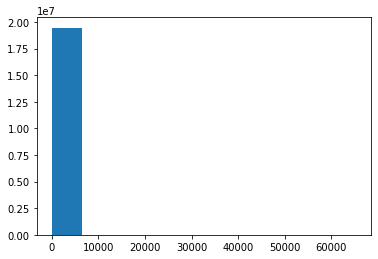

In [98]:
plt.hist(df['Sale (Dollars)'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f45e982d580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f45e9831d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f45e9818a30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f45e97b5370>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f45e97b5640>],
 'means': []}

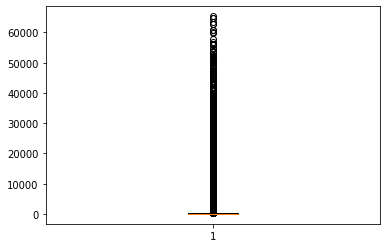

In [101]:
plt.boxplot(df['Sale (Dollars)'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f49500be1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f49500beca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f48175b98b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f49500be8e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4950749550>],
 'means': []}

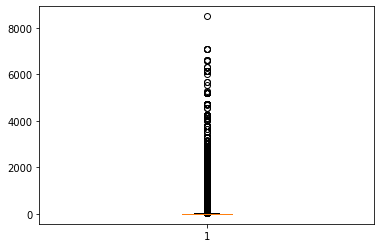

In [99]:
plt.boxplot(df['Volume Sold (Liters)'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f45e9809880>,
 'caps': [<matplotlib.lines.Line2D at 0x7f45e98142e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f45e9810b50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f45e9814880>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f45e9814b50>],
 'means': []}

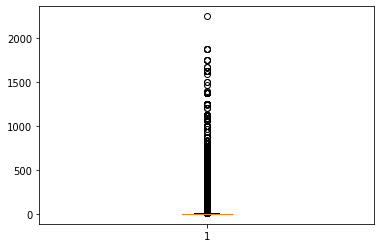

In [100]:
plt.boxplot(df['Volume Sold (Gallons)'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f45e97df0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f45e97df640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f48175b9580>],
 'medians': [<matplotlib.lines.Line2D at 0x7f45e97dfbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f45e97dfeb0>],
 'means': []}

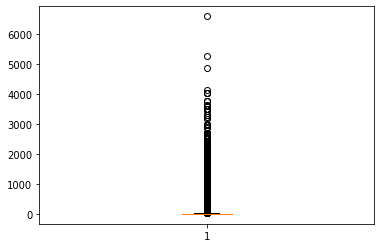

In [102]:
plt.boxplot(df['Bottles Sold'])

<font size=3>大部分的连续型数值都呈现出右偏的倾向

In [104]:
df.loc[df['Sale (Dollars)'] > 40000]['Store Name'].value_counts()

costco wholesale             39
hy-vee                       27
hy-vee food store            12
sam's club 6344               7
hy-vee wine and spirits       7
sam's club 8162               5
templeton distilling llc      4
hy-vee food store / fleur     1
sam's club 4973               1
sam's club 6472               1
sam's club 6514               1
sam's club 6432               1
sam's club 6568               1
sam's club 6979               1
central city 2                1
fareway stores                1
Name: Store Name, dtype: int64

In [105]:
df.loc[df['Volume Sold (Liters)'] > 2000]['Store Name'].value_counts()

costco wholesale                      201
fareway stores                        123
hy-vee food store                      85
hy-vee wine and spirits                71
sam's club 6344                        22
sam's club 8162                        21
hy-vee                                 19
hy-vee drugstore                       14
sam's club 6568                        10
sam's club 6514                         8
anamosa family foods                    5
brew coffee wine spirit and cigars      4
hy-vee wine & spirits                   3
jim and charlies affiliated             3
sam's club 6979                         3
jiffy                                   3
cvs pharmacy                            3
hy-vee food store / fleur               3
ida liquor                              2
pronto                                  2
hy-vee fort dodge wine and spirits      2
the music station                       2
schnucks                                2
sam's club 6432                   

In [106]:
df.loc[df['Volume Sold (Gallons)'] > 800]['Store Name'].value_counts()

costco wholesale           94
hy-vee wine and spirits    12
hy-vee food store           8
sam's club 6344             5
hy-vee                      5
sam's club 8162             1
sam's club 4973             1
sam's club 6472             1
sam's club 6514             1
sam's club 6432             1
sam's club 6568             1
sam's club 6979             1
fareway stores              1
Name: Store Name, dtype: int64

In [107]:
df.loc[df['Bottles Sold'] > 2000]['Store Name'].value_counts()

costco wholesale              78
hy-vee                        19
sam's club 8162               15
hy-vee food store             13
hy-vee wine and spirits       13
prime mart                     2
sam's club 6514                2
sam's club 6344                2
shop n save                    2
leo1                           2
mart stop                      1
southside liquor & tobacco     1
ali's liquor                   1
fareway stores                 1
sam's food                     1
hy-vee wine & spirits          1
Name: Store Name, dtype: int64

<font size=6>对数据异常值进行盖帽法处理，即当数据超过了上限u_75 + 1.5*IQR则把数据修改成最大上限值   若超过了下限u_25 - 1.5*IQR 则把数据修改成最小下限

In [18]:
## del_cols:不用盖帽法处理的列名集合
## df_data_1:待处理的数据框
def OutliersDeal(df_data_1 , del_cols ):
    import copy 
    df_data = copy.deepcopy(df_data_1.drop(del_cols , axis = 1))
    colnames = df_data.columns.tolist()
    for col_name in colnames:
        u_75 = df_data[col_name].quantile(q = 0.75)
        u_25 = df_data[col_name].quantile(q = 0.25)
        IQR = u_75 - u_25
        df_data.loc[df_data[col_name] > u_75 + 1.5*IQR , col_name] = u_75 + 1.5*IQR
        df_data.loc[df_data[col_name] < u_25 - 1.5*IQR , col_name] = u_25 - 1.5*IQR
        df_data_1[col_name] = df_data[col_name]
    return df_data_1

In [20]:
## 用盖帽法处理异常值
df = OutliersDeal(df, ['Invoice/Item Number',
 'Date',
 'Store Number',
 'Store Name',
 'City',
 'County',
 'Category Name',
 'Vendor Name',
 'Item Number',
 'Item Description',
 'Pack',
 'Bottle Volume (ml)',
 'State Bottle Cost',
 'State Bottle Retail'])
df.describe()

,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
count,1.948038e+07,1.948038e+07,1.948038e+07,1.948038e+07,1.948038e+07,19480377.0,1.948038e+07,1.948038e+07,1.948038e+07
mean,3.682958e+03,1.227179e+01,9.115331e+02,NaN,NaN,NaN,NaN,NaN,NaN
std,1.023130e+03,7.656573e+00,5.007550e+02,NaN,NaN,0.0,NaN,0.000000e+00,0.000000e+00
min,2.106000e+03,1.000000e+00,1.200000e+01,1.899414e-01,2.900391e-01,1.0,1.299805e+00,2.000427e-02,0.000000e+00
25%,2.613000e+03,6.000000e+00,7.500000e+02,5.500000e+00,8.250000e+00,3.0,3.150000e+01,1.500000e+00,3.999023e-01
50%,3.773000e+03,1.200000e+01,7.500000e+02,8.203125e+00,1.236719e+01,6.0,7.168750e+01,5.101562e+00,1.339844e+00
75%,4.495000e+03,1.200000e+01,1.000000e+03,1.204688e+01,1.807812e+01,12.0,1.393750e+02,1.050000e+01,2.769531e+00
max,9.938000e+03,3.360000e+02,3.150000e+04,7.680000e+03,1.152000e+04,25.5,3.012500e+02,2.400000e+01,6.324219e+00


<font size=4>提取经纬度并进行合并

In [21]:
useful_columns = ['Invoice/Item Number','Store Location']

with zipfile.ZipFile('autodl-nas/Iowa_Liquor_Sales.csv.zip','r') as zipobj:
    loc=zipobj.open('Iowa_Liquor_Sales.csv')
    #df = pd.read_csv('Iowa_Liquor_Sales.csv', parse_dates=['Date'], usecols=useful_columns,dtype=dtypes)
    
loc = pd.read_csv(loc, usecols=useful_columns)

In [22]:
loc

,Invoice/Item Number,Store Location
0,S24127700024,POINT (-93.597011 41.570844)
1,S15066200002,POINT (-93.596754 41.554101)
2,S19323500030,POINT (-95.385111 40.761736)
3,S23334500013,POINT (-93.572458 41.760989)
4,S09742200010,POINT (-92.277759 41.897052)
...,...,...
19666758,S10600200004,POINT (-95.29346 42.499481)
19666759,S23597800012,POINT (-96.376341 42.489845)
19666760,S29278700041,POINT (-93.561517 41.600476)
19666761,S04908000004,POINT (-92.727343 41.7283)


In [126]:
# loc['Store Location'][0].split(' ')

['POINT', '(-93.597011', '41.570844)']

In [136]:
# reg=r'POINT \((.*)\)'
# example=re.findall(reg,loc['Store Location'][0])

In [138]:
# example[0].split(' ')

['-93.597011', '41.570844']

In [ ]:
#reg=r'POINT \((.*)\)'

In [26]:
loc=loc.dropna()

In [27]:
reg=r'POINT \((.*)\)'
loc['location']= loc['Store Location'].map(lambda x:re.findall(reg,x)[0])


/tmp/ipykernel_262/432687171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc['location']= loc['Store Location'].map(lambda x:re.findall(reg,x)[0])


In [35]:
loc['longtitude']=loc['location'].map(lambda x:x.split(' ')[0])
loc['latitude']=loc['location'].map(lambda x:x.split(' ')[1])


/tmp/ipykernel_262/2300787339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc['longtitude']=loc['location'].map(lambda x:x.split(' ')[0])
/tmp/ipykernel_262/2300787339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc['latitude']=loc['location'].map(lambda x:x.split(' ')[1])


In [37]:
loc.loc[:,'Invoice/Item Number'] = loc.loc[:,'Invoice/Item Number'].str.lower().str.strip().str.split().str.join(' ')

/tmp/ipykernel_262/60798749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc.loc[:,'Invoice/Item Number'] = loc.loc[:,'Invoice/Item Number'].str.lower().str.strip().str.split().str.join(' ')


In [38]:
loc

,Invoice/Item Number,Store Location,location,longtitude,latitude
0,s24127700024,POINT (-93.597011 41.570844),-93.597011 41.570844,-93.597011,41.570844
1,s15066200002,POINT (-93.596754 41.554101),-93.596754 41.554101,-93.596754,41.554101
2,s19323500030,POINT (-95.385111 40.761736),-95.385111 40.761736,-95.385111,40.761736
3,s23334500013,POINT (-93.572458 41.760989),-93.572458 41.760989,-93.572458,41.760989
4,s09742200010,POINT (-92.277759 41.897052),-92.277759 41.897052,-92.277759,41.897052
...,...,...,...,...,...
19666758,s10600200004,POINT (-95.29346 42.499481),-95.29346 42.499481,-95.29346,42.499481
19666759,s23597800012,POINT (-96.376341 42.489845),-96.376341 42.489845,-96.376341,42.489845
19666760,s29278700041,POINT (-93.561517 41.600476),-93.561517 41.600476,-93.561517,41.600476
19666761,s04908000004,POINT (-92.727343 41.7283),-92.727343 41.7283,-92.727343,41.7283


In [39]:
df_clean=pd.merge(df,loc,how='left',left_on='Invoice/Item Number',right_on='Invoice/Item Number')

In [40]:
df_clean

,Invoice/Item Number,Date,Store Number,Store Name,City,County,Category Name,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Location,location,longtitude,latitude
0,s24127700024,2015-02-19,3678,"smoke shop, the",des moines,polk,vodka flavored,phillips beverage company,41783,uv blue raspberry vodka mini,6,500,4.890625,7.339844,2.0,14.679688,1.000000,0.260010,POINT (-93.597011 41.570844),-93.597011 41.570844,-93.597011,41.570844
1,s15066200002,2013-10-10,2633,hy-vee,des moines,polk,misc. imported cordials & liqueurs,mhw ltd,904969,sabe premiom sake double barrel,6,750,14.992188,22.484375,6.0,135.000000,4.500000,1.190430,POINT (-93.596754 41.554101),-93.596754 41.554101,-93.596754,41.554101
2,s19323500030,2014-06-03,2607,hy-vee wine and spirits,shenandoah,page,puerto rico & virgin islands rum,luxco-st louis,45277,paramount white rum,12,1000,4.339844,6.511719,12.0,78.125000,12.000000,3.169922,POINT (-95.385111 40.761736),-95.385111 40.761736,-95.385111,40.761736
3,s23334500013,2015-01-06,4810,kum & go,ankeny,polk,puerto rico & virgin islands rum,"bacardi u.s.a., inc.",43121,bacardi superior rum mini,12,500,5.539062,8.312500,1.0,8.312500,0.500000,0.130005,POINT (-93.572458 41.760989),-93.572458 41.760989,-93.572458,41.760989
4,s09742200010,2012-12-27,4025,karam kaur khasriya llc,belle plaine,benton,canadian whiskies,diageo americas,11298,crown royal canadian whisky,6,1750,31.000000,46.500000,2.0,93.000000,3.500000,0.919922,POINT (-92.277759 41.897052),-92.277759 41.897052,-92.277759,41.897052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19480372,s10600200004,2013-02-13,3864,hometown foods,schaller,sac,american cocktails,"sazerac co., inc.",59231,ice box mudslide,6,1750,5.750000,9.132812,6.0,54.781250,10.500000,2.769531,POINT (-95.29346 42.499481),-95.29346 42.499481,-95.29346,42.499481
19480373,s23597800012,2015-01-21,5065,circle s gordon drive,sioux city,woodbury,whiskey liqueur,"sazerac co., inc.",64863,fireball cinnamon whiskey,48,200,3.330078,5.000000,4.0,20.000000,0.799805,0.209961,POINT (-96.376341 42.489845),-96.376341 42.489845,-96.376341,42.489845
19480374,s29278700041,2015-11-24,3400,last stop beverage shop,des moines,polk,vodka 80 proof,phillips beverage company,37336,uv vodka,12,750,6.500000,9.750000,12.0,117.000000,9.000000,2.380859,POINT (-93.561517 41.600476),-93.561517 41.600476,-93.561517,41.600476
19480375,s04908000004,2012-04-05,2579,hy-vee food store,grinnell,poweshiek,puerto rico & virgin islands rum,"bacardi u.s.a., inc.",43128,bacardi superior rum,6,1750,14.671875,22.000000,6.0,132.000000,10.500000,2.769531,POINT (-92.727343 41.7283),-92.727343 41.7283,-92.727343,41.7283


In [42]:
df_clean=df_clean.drop(['Store Location','location'],axis=1)

In [44]:
gg=df_clean.to_csv('autodl-nas/data_clean_2.csv')

In [48]:
# 生成压缩文件
z=zipfile.ZipFile('autodl-nas/data_clean_2.zip','w',zipfile.ZIP_DEFLATED)
z.write('autodl-nas/data_clean_2.csv')
z.close()